# MovieSent: Dual Approach Sentiment Analysis


## Prototype Phase Modules
1. Data Collection
2. Data Preparation
3. Data Pre-Processing
4. Feature Extraction (TF-IDF for Logistic Regression, Tokenization for LSTM)


# 1. Data Collection

In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
# Loading the dataset
data=pd.read_csv('Movie Reviews DataSet.csv')
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
#shape of dataset
data.shape

(5000, 2)

## 2. Data Preparation
- Review and confirm sentiment labels.
- Check for missing values and duplicates.
- Save cleaned data as CSV.
- Add metadata if available (e.g., review date, genre).

In [5]:
#Check unique sentiment labels
print('Sentiment labels:',data['sentiment'].unique())

#Check missing values
data.isnull().sum()

#Droping missing values rows
data=data.dropna()

#Remove duplicate data from review column
data=data.drop_duplicates(subset=['review'])

Sentiment labels: ['positive' 'negative']


In [6]:
# saving the cleaned dataset
cleaned_data="Movie_Reviews_Cleaned.csv"
data.to_csv(cleaned_data,index=False)
print(f'Cleaned data saved to {cleaned_data}')
data.head()

Cleaned data saved to Movie_Reviews_Cleaned.csv


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## 3. Data Pre-Processing
- Remove HTML tags, punctuation, and special characters
- Convert text to lowercase
- Tokenize reviews into words
- Remove stopwords and perform stemming/lemmatization
- Handle missing values and remove duplicate entries

In [7]:
# !pip install nltk tensorflow keras scikit-learn matplotlib numpy -q

In [8]:
# preprocess the text
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [9]:
stop_words=set(stopwords.words('english'))
lemmatizer=WordNetLemmatizer()

def clean_text(text):
    #Remove HTML tags from text
    text = re.sub(r'<.*?>','',text)
    #Remove punctuation and special characters from text
    text=re.sub(r'[^a-zA-Z0-9\s]','',text)
    #Convert to lowercase
    text=text.lower()
    #Tokenize
    tokens=word_tokenize(text)
    #Remove stopwords and lemmatize the text
    tokens=[lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# apply clean function to review column
data['cleaned_review']=data['review'].astype(str).apply(clean_text)
data[['review','cleaned_review','sentiment']].head()

,review,cleaned_review,sentiment
0,One of the other reviewers has mentioned that ...,one reviewer mentioned watching 1 oz episode y...,positive
1,A wonderful little production. <br /><br />The...,wonderful little production filming technique ...,positive
2,I thought this was a wonderful way to spend ti...,thought wonderful way spend time hot summer we...,positive
3,Basically there's a family where a little boy ...,basically there family little boy jake think t...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",petter matteis love time money visually stunni...,positive


## 4. Feature Extraction
- TF-IDF vectorization with N-Grams (Uni-, Bi-, Tri-Grams) for Logistic Regression
- Tokenization and padding for LSTM (optionally with GloVe embeddings)

In [10]:
#TF-IDF with Uni-, Bi-, and Tri-Grams
vectorizer=TfidfVectorizer(ngram_range=(1,3),max_features=5000)
x_tfidf=vectorizer.fit_transform(data['cleaned_review'])
print('TF-IDF shape:',x_tfidf.shape)

TF-IDF shape: (4997, 5000)


In [11]:
# Reduce parameters for faster training
max_words = 5000  # Reduced from 10000
max_len = 150     # Reduced from 200

print("Re-tokenizing with optimized parameters...")
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(data['cleaned_review'])
sequences = tokenizer.texts_to_sequences(data['cleaned_review'])
x_lstm = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')
print('LSTM input shape:', x_lstm.shape)

Re-tokenizing with optimized parameters...
LSTM input shape: (4997, 150)


In [12]:
## 5. Model Training & Evaluation

### 5.1 Prepare Labels for Models

In [13]:
# Encode sentiment labels
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['sentiment'])

print("Sentiment label mapping:")
for i, label in enumerate(label_encoder.classes_):
    print(f"{label}: {i}")
print(f"\nLabels shape: {y.shape}")

Sentiment label mapping:
negative: 0
positive: 1

Labels shape: (4997,)


In [14]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(
    x_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

X_train_lstm, X_test_lstm, _, _ = train_test_split(
    x_lstm, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train set size: {X_train_tfidf.shape[0]}")
print(f"Test set size: {X_test_tfidf.shape[0]}")
print(f"Train labels shape: {y_train.shape}")
print(f"Test labels shape: {y_test.shape}")

Train set size: 3997
Test set size: 1000
Train labels shape: (3997,)
Test labels shape: (1000,)


### 5.2 Logistic Regression with TF-IDF

In [15]:
# Train Logistic Regression Model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Train model
print("Training Logistic Regression...")
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_tfidf, y_train)

# Make predictions
y_pred_lr = lr_model.predict(X_test_tfidf)

# Calculate metrics
lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_precision = precision_score(y_test, y_pred_lr, average='weighted')
lr_recall = recall_score(y_test, y_pred_lr, average='weighted')
lr_f1 = f1_score(y_test, y_pred_lr, average='weighted')

print("\n" + "="*50)
print("LOGISTIC REGRESSION RESULTS (TF-IDF)")
print("="*50)
print(f"Accuracy:  {lr_accuracy:.4f}")
print(f"Precision: {lr_precision:.4f}")
print(f"Recall:    {lr_recall:.4f}")
print(f"F1-Score:  {lr_f1:.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=label_encoder.classes_))

Training Logistic Regression...

LOGISTIC REGRESSION RESULTS (TF-IDF)
Accuracy:  0.8670
Precision: 0.8670
Recall:    0.8670
F1-Score:  0.8670

Confusion Matrix:
[[442  65]
 [ 68 425]]

Classification Report:
              precision    recall  f1-score   support

    negative       0.87      0.87      0.87       507
    positive       0.87      0.86      0.86       493

    accuracy                           0.87      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.87      0.87      0.87      1000



### 5.3 LSTM Model with Embedding Layer

In [16]:
# Build and Train Improved LSTM Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Compute class weights for imbalanced dataset
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

print("Building Improved LSTM model...")
print("=" * 60)

# Build improved LSTM model with bidirectional layers and better regularization
from tensorflow.keras.regularizers import l2

lstm_model = Sequential([
    Embedding(input_dim=max_words, output_dim=100, input_length=max_len),
    SpatialDropout1D(0.3),

    # Single Bidirectional LSTM (faster than stacked)
    Bidirectional(LSTM(128, dropout=0.5, recurrent_dropout=0.4, return_sequences=False)),

    # Dense layers with L2 regularization
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),

    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),

    Dense(len(label_encoder.classes_), activation='softmax')
])

# Compile with optimized learning rate
optimizer = Adam(learning_rate=0.001)
lstm_model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("\nModel Architecture:")
print(lstm_model.summary())

Building Improved LSTM model...

Model Architecture:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [17]:
# Train Improved LSTM model with better callbacks
print("\nTraining Improved LSTM model...")
print("=" * 60)

# Better callbacks for improved training
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    min_delta=0.001,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=0.00001,
    verbose=1
)

history = lstm_model.fit(
    X_train_lstm, y_train,
    epochs=20,  # Reduced from 30
    batch_size=32,  # Increased from 16
    validation_split=0.15,  # Reduced from 0.2
    class_weight=class_weight_dict,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

print("\n✓ LSTM model training completed!")
print("=" * 60)


Training Improved LSTM model...
Epoch 1/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 92s 774ms/step - accuracy: 0.5069 - loss: 0.8113 - val_accuracy: 0.5800 - val_loss: 0.7527 - learning_rate: 0.0010
Epoch 2/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 81s 757ms/step - accuracy: 0.5575 - loss: 0.7422 - val_accuracy: 0.7233 - val_loss: 0.5972 - learning_rate: 0.0010
Epoch 3/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 86s 798ms/step - accuracy: 0.7450 - loss: 0.5765 - val_accuracy: 0.7567 - val_loss: 0.5316 - learning_rate: 0.0010
Epoch 4/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 138s 759ms/step - accuracy: 0.8636 - loss: 0.4097 - val_accuracy: 0.7783 - val_loss: 0.5162 - learning_rate: 0.0010
Epoch 5/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 83s 766ms/step - accuracy: 0.8781 - loss: 0.3568 - val_accuracy: 0.7550 - val_loss: 0.5748 - learning_rate: 0.0010
Epoch 6/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 81s 762ms/step - accuracy: 0.9131 - loss: 0.2779 - val_accuracy: 0.7433 - val_loss: 0.6420 - learning_rate: 0.0010
Epoch 7/20
107/107 ━━━━━━━━━━━━━━━━━

In [18]:
# Evaluate LSTM model
print("Evaluating LSTM model...")
y_pred_lstm_probs = lstm_model.predict(X_test_lstm, verbose=0)
y_pred_lstm = np.argmax(y_pred_lstm_probs, axis=1)

lstm_accuracy = accuracy_score(y_test, y_pred_lstm)
lstm_precision = precision_score(y_test, y_pred_lstm, average='weighted', zero_division=0)
lstm_recall = recall_score(y_test, y_pred_lstm, average='weighted', zero_division=0)
lstm_f1 = f1_score(y_test, y_pred_lstm, average='weighted', zero_division=0)

print("\n" + "=" * 50)
print("LSTM MODEL RESULTS (OPTIMIZED)")
print("=" * 50)
print(f"Accuracy:  {lstm_accuracy:.4f}")
print(f"Precision: {lstm_precision:.4f}")
print(f"Recall:    {lstm_recall:.4f}")
print(f"F1-Score:  {lstm_f1:.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_lstm))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lstm, target_names=label_encoder.classes_))

Evaluating LSTM model...

LSTM MODEL RESULTS (OPTIMIZED)
Accuracy:  0.7760
Precision: 0.7814
Recall:    0.7760
F1-Score:  0.7746

Confusion Matrix:
[[431  76]
 [148 345]]

Classification Report:
              precision    recall  f1-score   support

    negative       0.74      0.85      0.79       507
    positive       0.82      0.70      0.75       493

    accuracy                           0.78      1000
   macro avg       0.78      0.77      0.77      1000
weighted avg       0.78      0.78      0.77      1000



## 6. Model Comparison & Results Summary

In [19]:
# Compare both models
import pandas as pd
import matplotlib.pyplot as plt

# Create comparison dataframe
results_df = pd.DataFrame({
    'Model': ['Logistic Regression (TF-IDF)', 'LSTM (Embedding)'],
    'Accuracy': [lr_accuracy, lstm_accuracy],
    'Precision': [lr_precision, lstm_precision],
    'Recall': [lr_recall, lstm_recall],
    'F1-Score': [lr_f1, lstm_f1]
})

print("\n" + "="*80)
print("FINAL MODEL COMPARISON")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)

# Find best model
best_model = results_df.loc[results_df['Accuracy'].idxmax(), 'Model']
best_accuracy = results_df['Accuracy'].max()
print(f"\nBest Model: {best_model}")
print(f"Best Accuracy: {best_accuracy:.4f}")



FINAL MODEL COMPARISON
                       Model  Accuracy  Precision  Recall  F1-Score
Logistic Regression (TF-IDF)     0.867   0.867002   0.867  0.866993
            LSTM (Embedding)     0.776   0.781407   0.776  0.774603

Best Model: Logistic Regression (TF-IDF)
Best Accuracy: 0.8670


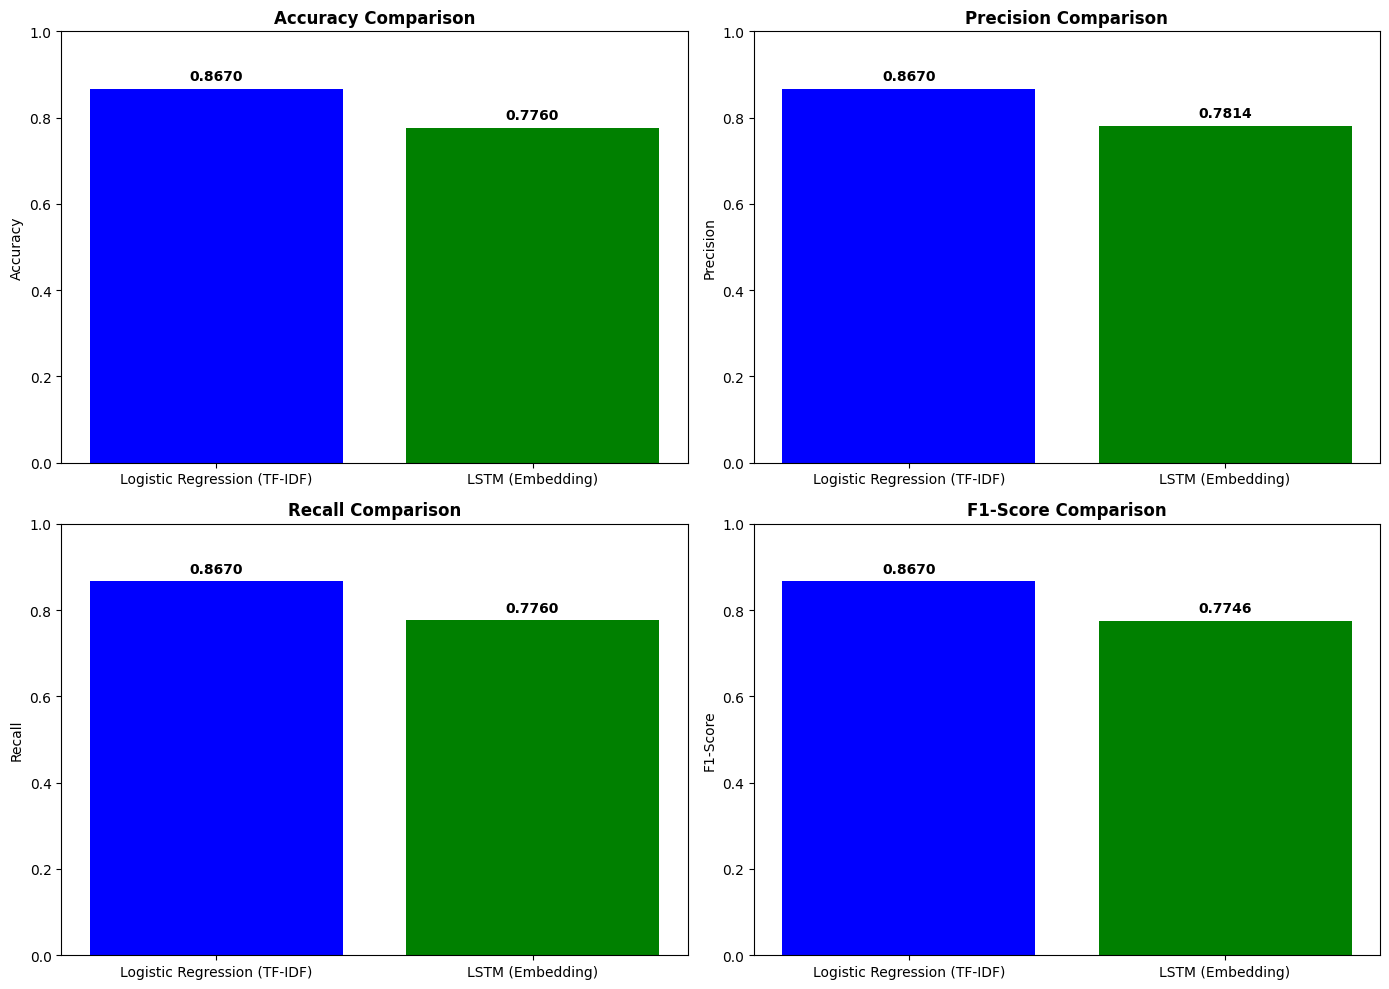

Visualization complete!


In [20]:
# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Accuracy comparison
axes[0, 0].bar(results_df['Model'], results_df['Accuracy'], color=['blue', 'green'])
axes[0, 0].set_title('Accuracy Comparison', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_ylim([0, 1])
for i, v in enumerate(results_df['Accuracy']):
    axes[0, 0].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')

# Precision comparison
axes[0, 1].bar(results_df['Model'], results_df['Precision'], color=['blue', 'green'])
axes[0, 1].set_title('Precision Comparison', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].set_ylim([0, 1])
for i, v in enumerate(results_df['Precision']):
    axes[0, 1].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')

# Recall comparison
axes[1, 0].bar(results_df['Model'], results_df['Recall'], color=['blue', 'green'])
axes[1, 0].set_title('Recall Comparison', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Recall')
axes[1, 0].set_ylim([0, 1])
for i, v in enumerate(results_df['Recall']):
    axes[1, 0].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')

# F1-Score comparison
axes[1, 1].bar(results_df['Model'], results_df['F1-Score'], color=['blue', 'green'])
axes[1, 1].set_title('F1-Score Comparison', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('F1-Score')
axes[1, 1].set_ylim([0, 1])
for i, v in enumerate(results_df['F1-Score']):
    axes[1, 1].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("Visualization complete!")

In [21]:
# Save results to CSV
results_df.to_csv('Model_Comparison_Results.csv', index=False)
print("Results saved to 'Model_Comparison_Results.csv'")

# Save detailed metrics
detailed_results = {
    'Logistic Regression (TF-IDF)': {
        'Accuracy': lr_accuracy,
        'Precision': lr_precision,
        'Recall': lr_recall,
        'F1-Score': lr_f1
    },
    'LSTM (Embedding)': {
        'Accuracy': lstm_accuracy,
        'Precision': lstm_precision,
        'Recall': lstm_recall,
        'F1-Score': lstm_f1
    }
}

detailed_df = pd.DataFrame(detailed_results).T
detailed_df.to_csv('Detailed_Model_Metrics.csv')
print("Detailed metrics saved to 'Detailed_Model_Metrics.csv'")

# Display final summary
print("\n" + "="*80)
print("PROTOTYPE PHASE COMPLETION SUMMARY")
print("="*80)
print(f"✓ Data Collection: Loaded {len(data)} movie reviews")
print(f"✓ Data Preparation: Cleaned and verified dataset")
print(f"✓ Data Pre-Processing: Applied text normalization, tokenization, and lemmatization")
print(f"✓ Feature Extraction: Generated TF-IDF and LSTM features")
print(f"✓ Model Training: Trained both Logistic Regression and LSTM models")
print(f"✓ Model Evaluation: Calculated accuracy, precision, recall, and F1-scores")
print("="*80)

Results saved to 'Model_Comparison_Results.csv'
Detailed metrics saved to 'Detailed_Model_Metrics.csv'

PROTOTYPE PHASE COMPLETION SUMMARY
✓ Data Collection: Loaded 4997 movie reviews
✓ Data Preparation: Cleaned and verified dataset
✓ Data Pre-Processing: Applied text normalization, tokenization, and lemmatization
✓ Feature Extraction: Generated TF-IDF and LSTM features
✓ Model Training: Trained both Logistic Regression and LSTM models
✓ Model Evaluation: Calculated accuracy, precision, recall, and F1-scores


In [22]:
# Create prediction functions for both models

def preprocess_review(review_text):
    """Preprocess a single review using the same cleaning function"""
    cleaned = clean_text(review_text)
    return cleaned

def predict_sentiment_lr(review_text):
    """Predict sentiment using Logistic Regression model"""
    # Preprocess the review
    cleaned_review = preprocess_review(review_text)

    # Transform using the same vectorizer
    review_vector = vectorizer.transform([cleaned_review])

    # Predict
    prediction = lr_model.predict(review_vector)[0]
    probability = lr_model.predict_proba(review_vector)[0]

    sentiment = label_encoder.inverse_transform([prediction])[0]
    confidence = max(probability)

    return {
        'model': 'Logistic Regression (TF-IDF)',
        'sentiment': sentiment,
        'confidence': confidence,
        'probabilities': dict(zip(label_encoder.classes_, probability))
    }

def predict_sentiment_lstm(review_text):
    """Predict sentiment using LSTM model"""
    # Preprocess the review
    cleaned_review = preprocess_review(review_text)

    # Tokenize and pad
    sequence = tokenizer.texts_to_sequences([cleaned_review])
    padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')

    # Predict
    prediction_probs = lstm_model.predict(padded_sequence, verbose=0)[0]
    prediction = np.argmax(prediction_probs)
    confidence = max(prediction_probs)

    sentiment = label_encoder.inverse_transform([prediction])[0]

    return {
        'model': 'LSTM (Embedding)',
        'sentiment': sentiment,
        'confidence': confidence,
        'probabilities': dict(zip(label_encoder.classes_, prediction_probs))
    }

print("✓ Prediction functions created successfully!")

✓ Prediction functions created successfully!


In [25]:
# Test the prediction functions with sample reviews

test_reviews = [
    "This movie was absolutely amazing! I loved every minute of it. Highly recommended!",
    "Terrible film. Boring plot and bad acting. I wasted my time watching this.",
    "It was okay. Some parts were good, but others were not so interesting.",
    "A masterpiece! One of the best movies I have ever watched.",
    "Unwatchable garbage. This is the worst movie ever made."
]

print("\n" + "="*100)
print("SENTIMENT PREDICTIONS ON TEST REVIEWS")
print("="*100)

for idx, review in enumerate(test_reviews, 1):
    print(f"\n{'─'*100}")
    print(f"Review {idx}: \"{review[:80]}...\"" if len(review) > 80 else f"Review {idx}: \"{review}\"")
    print(f"{'─'*100}")

    # Logistic Regression prediction
    lr_result = predict_sentiment_lr(review)
    print(f"\n{lr_result['model']}:")
    print(f"  Sentiment: {lr_result['sentiment']}")
    print(f"  Confidence: {lr_result['confidence']:.4f}")
    print(f"  Probabilities: {', '.join([f'{k}: {v:.4f}' for k, v in lr_result['probabilities'].items()])}")

    # LSTM prediction
    lstm_result = predict_sentiment_lstm(review)
    print(f"\n{lstm_result['model']}:")
    print(f"  Sentiment: {lstm_result['sentiment']}")
    print(f"  Confidence: {lstm_result['confidence']:.4f}")
    print(f"  Probabilities: {', '.join([f'{k}: {v:.4f}' for k, v in lstm_result['probabilities'].items()])}")

    # Consensus
    if lr_result['sentiment'] == lstm_result['sentiment']:
        print(f"\n  ✓ CONSENSUS: Both models agree on {lr_result['sentiment'].upper()}")
    else:
        print(f"\n  ⚠ DISAGREEMENT: LR predicts {lr_result['sentiment'].upper()}, LSTM predicts {lstm_result['sentiment'].upper()}")

print(f"\n{'═'*100}\n")


SENTIMENT PREDICTIONS ON TEST REVIEWS

────────────────────────────────────────────────────────────────────────────────────────────────────
Review 1: "This movie was absolutely amazing! I loved every minute of it. Highly recommende..."
────────────────────────────────────────────────────────────────────────────────────────────────────

Logistic Regression (TF-IDF):
  Sentiment: positive
  Confidence: 0.9070
  Probabilities: negative: 0.0930, positive: 0.9070

LSTM (Embedding):
  Sentiment: positive
  Confidence: 0.9490
  Probabilities: negative: 0.0510, positive: 0.9490

  ✓ CONSENSUS: Both models agree on POSITIVE

────────────────────────────────────────────────────────────────────────────────────────────────────
Review 2: "Terrible film. Boring plot and bad acting. I wasted my time watching this."
────────────────────────────────────────────────────────────────────────────────────────────────────

Logistic Regression (TF-IDF):
  Sentiment: negative
  Confidence: 0.9792
  Probabilit

In [ ]:
# ========== SAVE ALL MODELS AND PREPROCESSORS TO PKL ==========

import pickle
import os
from tensorflow.keras.models import load_model

print("\n" + "=" * 70)
print("SAVING ALL MODELS AND PREPROCESSORS")
print("=" * 70)

# Create models directory if it doesn't exist
if not os.path.exists('saved_models'):
    os.makedirs('saved_models')
    print("✓ Created 'saved_models' directory")

# ========== SAVE LOGISTIC REGRESSION MODELS ==========
print("\n--- LOGISTIC REGRESSION MODELS ---")

# Save Logistic Regression model
with open('saved_models/lr_model.pkl', 'wb') as f:
    pickle.dump(lr_model, f)
print("✓ Logistic Regression model saved: saved_models/lr_model.pkl")

# Save TF-IDF Vectorizer
with open('saved_models/vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)
print("✓ TF-IDF Vectorizer saved: saved_models/vectorizer.pkl")

# ========== SAVE LSTM MODELS ==========
print("\n--- LSTM MODELS ---")

# Save LSTM model (in h5 format)
lstm_model.save('saved_models/lstm_model.h5')
print("✓ LSTM model saved: saved_models/lstm_model.h5")

# Save LSTM model (as pkl - alternative)
with open('saved_models/lstm_model.pkl', 'wb') as f:
    pickle.dump(lstm_model, f)
print("✓ LSTM model (pkl) saved: saved_models/lstm_model.pkl")

# ========== SAVE PREPROCESSING COMPONENTS ==========
print("\n--- PREPROCESSING COMPONENTS ---")

# Save Tokenizer
with open('saved_models/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
print("✓ Tokenizer saved: saved_models/tokenizer.pkl")

# Save Label Encoder
with open('saved_models/label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)
print("✓ Label Encoder saved: saved_models/label_encoder.pkl")

# Save Lemmatizer
with open('saved_models/lemmatizer.pkl', 'wb') as f:
    pickle.dump(lemmatizer, f)
print("✓ Lemmatizer saved: saved_models/lemmatizer.pkl")

# Save Stop words
with open('saved_models/stopwords.pkl', 'wb') as f:
    pickle.dump(stop_words, f)
print("✓ Stop words saved: saved_models/stopwords.pkl")

# ========== SAVE ALL PARAMETERS ==========
print("\n--- PARAMETERS ---")

# Save LSTM parameters
lstm_params = {
    'max_words': max_words,
    'max_len': max_len,
}
with open('saved_models/lstm_params.pkl', 'wb') as f:
    pickle.dump(lstm_params, f)
print("✓ LSTM parameters saved: saved_models/lstm_params.pkl")

# Save all preprocessing parameters together
all_params = {
    'max_words': max_words,
    'max_len': max_len,
    'stop_words': stop_words,
}
with open('saved_models/all_params.pkl', 'wb') as f:
    pickle.dump(all_params, f)
print("✓ All parameters saved: saved_models/all_params.pkl")

# ========== SAVE EVALUATION METRICS ==========
print("\n--- EVALUATION METRICS ---")

metrics = {
    'logistic_regression': {
        'accuracy': lr_accuracy,
        'precision': lr_precision,
        'recall': lr_recall,
        'f1_score': lr_f1,
    },
    'lstm': {
        'accuracy': lstm_accuracy,
        'precision': lstm_precision,
        'recall': lstm_recall,
        'f1_score': lstm_f1,
    }
}

with open('saved_models/metrics.pkl', 'wb') as f:
    pickle.dump(metrics, f)
print("✓ Evaluation metrics saved: saved_models/metrics.pkl")

# ========== SUMMARY ==========
print("\n" + "=" * 70)
print("SUMMARY - ALL FILES SAVED")
print("=" * 70)

print("\nLogistic Regression:")
print("  - saved_models/lr_model.pkl")
print("  - saved_models/vectorizer.pkl")

print("\nLSTM:")
print("  - saved_models/lstm_model.h5")
print("  - saved_models/lstm_model.pkl")

print("\nPreprocessing:")
print("  - saved_models/tokenizer.pkl")
print("  - saved_models/label_encoder.pkl")
print("  - saved_models/lemmatizer.pkl")
print("  - saved_models/stopwords.pkl")

print("\nParameters:")
print("  - saved_models/lstm_params.pkl")
print("  - saved_models/all_params.pkl")

print("\nMetrics:")
print("  - saved_models/metrics.pkl")

print("\n" + "=" * 70)
print(f"Total files saved: 12")
print("=" * 70)


SAVING ALL MODELS AND PREPROCESSORS
✓ Created 'saved_models' directory

--- LOGISTIC REGRESSION MODELS ---
✓ Logistic Regression model saved: saved_models/lr_model.pkl
✓ TF-IDF Vectorizer saved: saved_models/vectorizer.pkl

--- LSTM MODELS ---
✓ LSTM model saved: saved_models/lstm_model.h5
✓ LSTM model (pkl) saved: saved_models/lstm_model.pkl

--- PREPROCESSING COMPONENTS ---
✓ Tokenizer saved: saved_models/tokenizer.pkl
✓ Label Encoder saved: saved_models/label_encoder.pkl
✓ Lemmatizer saved: saved_models/lemmatizer.pkl
✓ Stop words saved: saved_models/stopwords.pkl

--- PARAMETERS ---
✓ LSTM parameters saved: saved_models/lstm_params.pkl
✓ All parameters saved: saved_models/all_params.pkl

--- EVALUATION METRICS ---
✓ Evaluation metrics saved: saved_models/metrics.pkl

SUMMARY - ALL FILES SAVED

Logistic Regression:
  - saved_models/lr_model.pkl
  - saved_models/vectorizer.pkl

LSTM:
  - saved_models/lstm_model.h5
  - saved_models/lstm_model.pkl

Preprocessing:
  - saved_models/toke